In [226]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import statsmodels.api as sm
from math import sqrt


In [227]:
## -- include price lr model --

# part 1 : selcet variables
raw_data = pd.read_excel("core_data.xlsx").dropna()
data = raw_data.drop(["pre_day_price", "pre_year_price"], axis=1)

X = data.drop(["DATE", "avg_price"], axis=1)
y = data["avg_price"]

variables = X.columns.tolist()
selected_variables = []
sl_enter = 0.05
sv_per_step = []
adjusted_r_squared = []
steps =[]
step = 0

# loop
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder)
    
    for col in remainder:
        X_temp = X[selected_variables + [col]]
        X_temp = sm.add_constant(X_temp)
        model = sm.OLS(y, X_temp).fit()
        pval[col] = model.pvalues[col]
        
    min_pval = pval.min()
    if min_pval < sl_enter:
        selected_variables.append(pval.idxmin())
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y, sm.add_constant(X[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    
    else:
        break

# result    
selected_variables

/var/folders/0t/f_9d1d5d2qv03s28lgq_4b7r0000gn/T/ipykernel_87795/1936965770.py:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval = pd.Series(index=remainder)
/var/folders/0t/f_9d1d5d2qv03s28lgq_4b7r0000gn/T/ipykernel_87795/1936965770.py:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval = pd.Series(index=remainder)
/var/folders/0t/f_9d1d5d2qv03s28lgq_4b7r0000gn/T/ipykernel_87795/1936965770.py:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval = pd.Series(index=remainder)
/var/folders/0t/f_9d1d5d2qv03s28lgq_4b7r0000gn/T/ipykernel_87795/1936965770.py:21: FutureWarning: The default dtype for empty Series will be 'object' instead of

['pre_7day_price',
 'average_temperature',
 'CPI',
 'fall_income',
 'input_labor',
 'fresh index']

/var/folders/0t/f_9d1d5d2qv03s28lgq_4b7r0000gn/T/ipykernel_87795/3289188651.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_train, y_test = y[:train_size], y[train_size:]
/var/folders/0t/f_9d1d5d2qv03s28lgq_4b7r0000gn/T/ipykernel_87795/3289188651.py:12: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  index_date = data["DATE"][train_size:]


Mean Squared Error:  0.0026000730236162856
R-squared:  0.7591221980882348


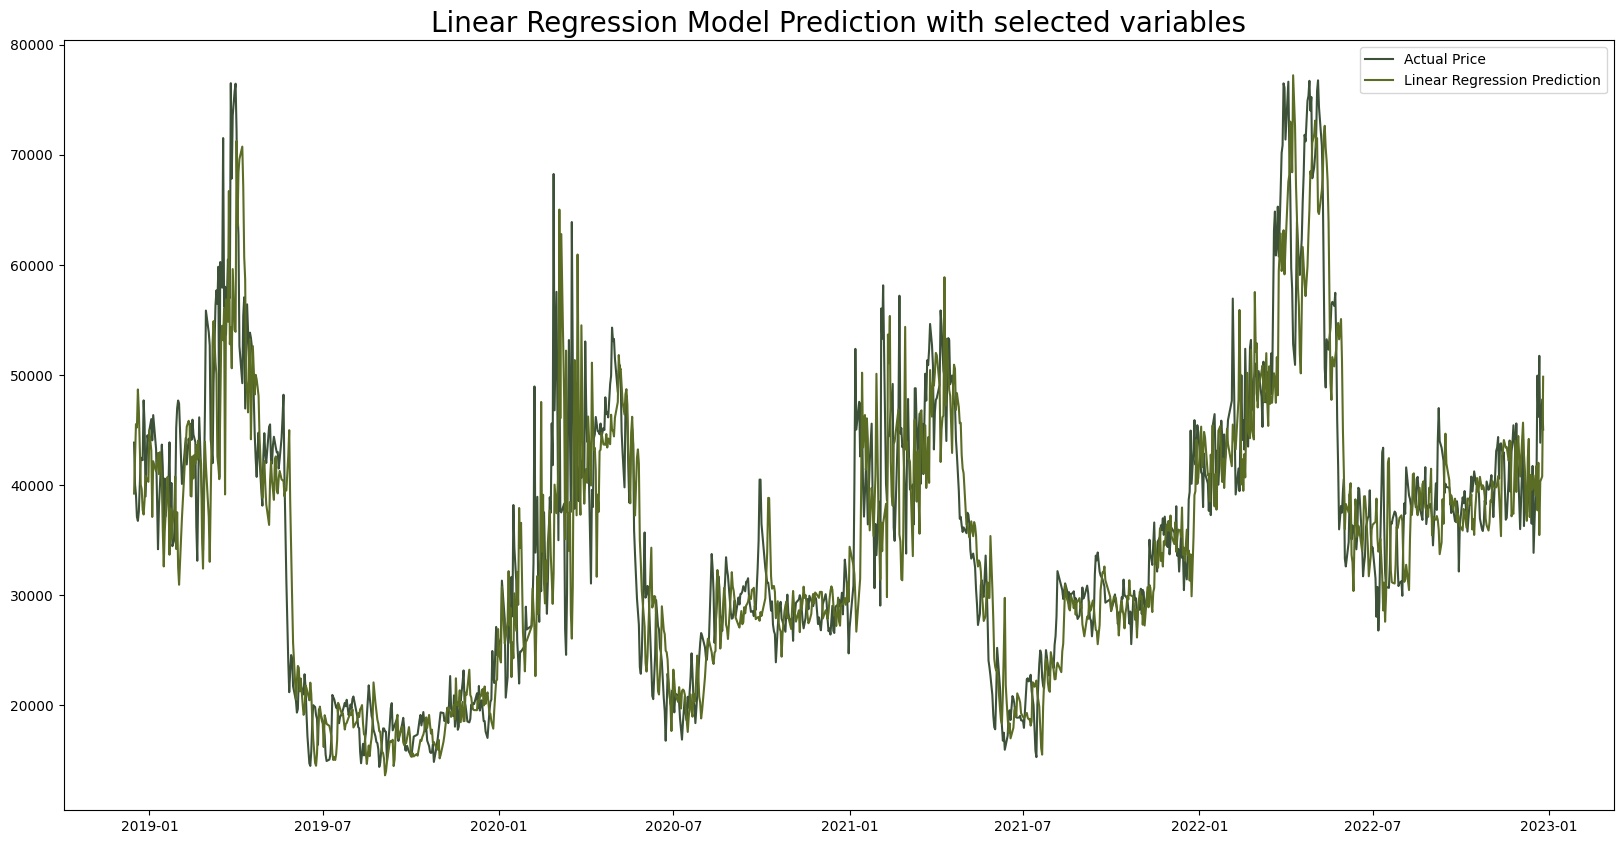

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.969
Model:                            OLS   Adj. R-squared (uncentered):              0.969
Method:                 Least Squares   F-statistic:                          2.542e+04
Date:                Mon, 25 Nov 2024   Prob (F-statistic):                        0.00
Time:                        12:19:54   Log-Likelihood:                          9518.2
No. Observations:                4885   AIC:                                 -1.902e+04
Df Residuals:                    4879   BIC:                                 -1.899e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

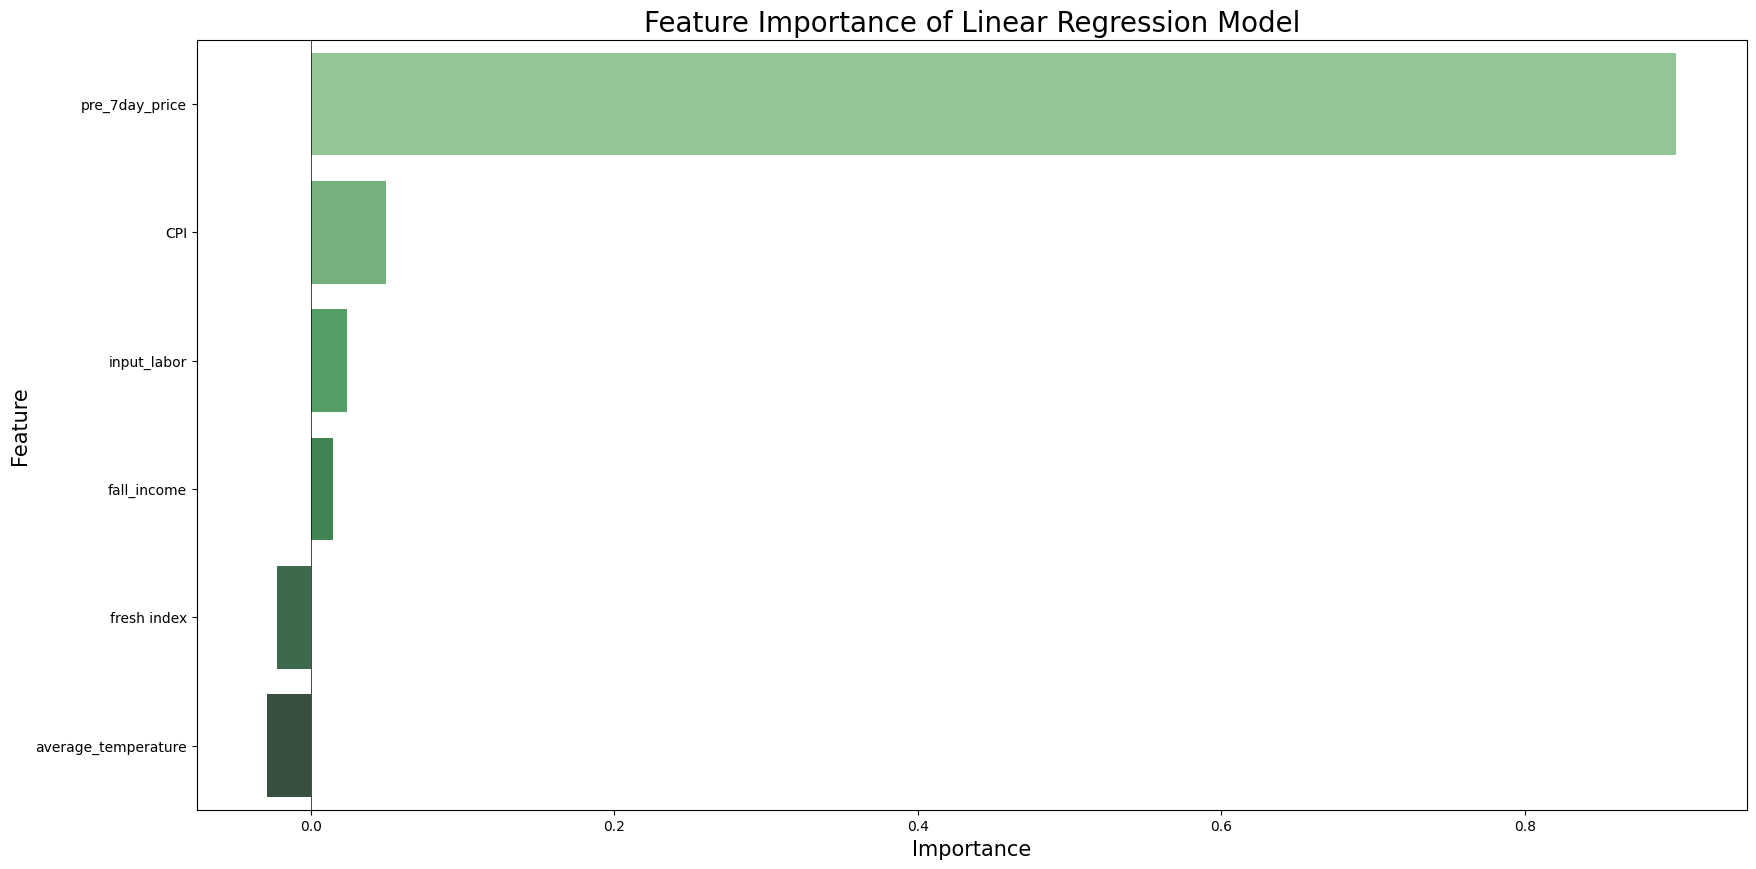

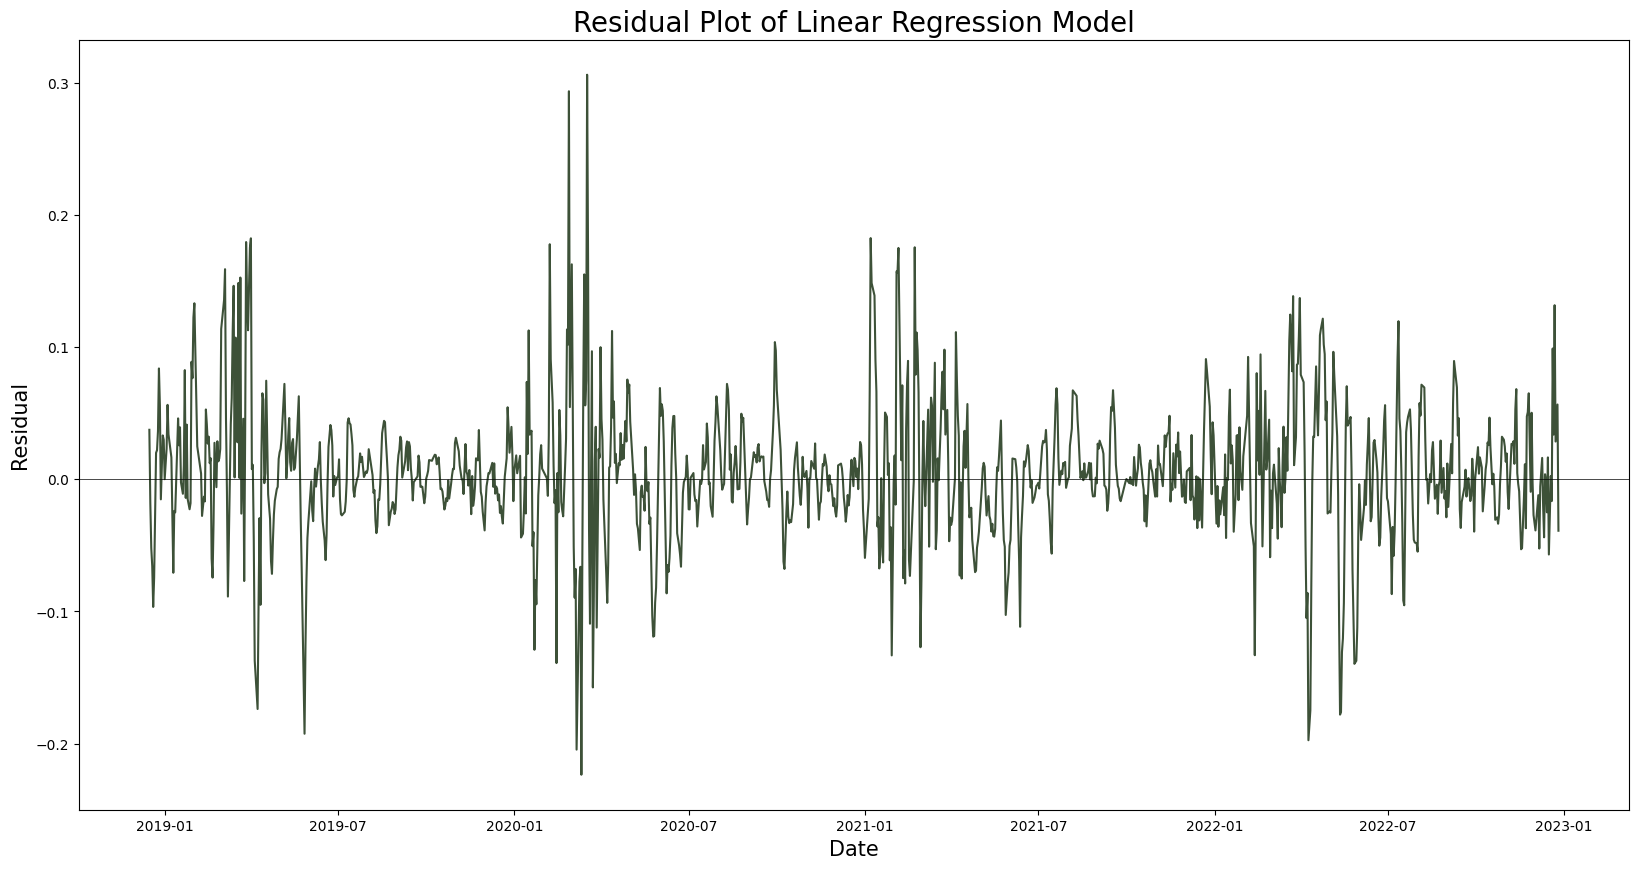

In [228]:
# part 2 : lr model
from sklearn.linear_model import LinearRegression

# input data and target data
X = data[selected_variables]
y = data["avg_price"]

# train set 80%, test set 20%
train_size = int(len(data) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:] 
index_date = data["DATE"][train_size:]

# MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = scaler.fit_transform(np.array(y_train).reshape(-1, 1)).reshape(-1)
y_test = scaler.transform(np.array(y_test).reshape(-1, 1)).reshape(-1)

# lr model
lr = LinearRegression()
lr.fit(X_train, y_train) 

# prediction 
y_pred = lr.predict(X_test) 

# evaluation
from sklearn.metrics import mean_squared_error
lr_mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: ", lr_mse)

# r-squared 
from sklearn.metrics import r2_score
lr_r2 = r2_score(y_test, y_pred)
print("R-squared: ", lr_r2)


# dataframe of the result
rescaled_y_test = scaler.inverse_transform(np.array(y_test).reshape(-1, 1)).reshape(-1)
rescaled_y_pred = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).reshape(-1)
result = pd.DataFrame({"Actual Price": rescaled_y_test, "Linear Regression Prediction": rescaled_y_pred},
                      index=index_date)


# plot 
plt.figure(figsize=(20, 10))
plt.plot(result["Actual Price"], label="Actual Price", color="#3D5138")
plt.plot(result["Linear Regression Prediction"], label="Linear Regression Prediction", color="#5B6C25")
plt.title("Linear Regression Model Prediction with selected variables", fontsize=20)
plt.legend()
plt.show()

# part 3 : cofficients
olr = sm.OLS(y_train, X_train).fit()
print(olr.summary()) 


# part 4 : feature importance
feature_importance = pd.DataFrame({"Feature": selected_variables, "Importance": lr.coef_})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False) 

plt.figure(figsize=(20, 10))
sns.barplot(x="Importance", y="Feature", data=feature_importance, palette="Greens_d") 
plt.title("Feature Importance of Linear Regression Model", fontsize=20) 
plt.axvline(x=0, color="Black", linewidth=0.5)
plt.xlabel("Importance", fontsize=15)
plt.ylabel("Feature", fontsize=15)
plt.show()

# part 5 : residual plot
residual = y_test - y_pred 
plt.figure(figsize=(20, 10)) 
plt.plot(index_date ,residual, color="#3D5138") 
plt.axhline(y=0, color="Black", linewidth=0.5) 
plt.title("Residual Plot of Linear Regression Model", fontsize=20) 
plt.xlabel("Date", fontsize=15) 
plt.ylabel("Residual", fontsize=15) 
plt.show() 


/var/folders/0t/f_9d1d5d2qv03s28lgq_4b7r0000gn/T/ipykernel_87795/1544438824.py:14: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_train, y_test = y[:train_size], y[train_size:]


Best alpha:  {'alpha': 0.001}
MSE of optimized Lasso Regression model:  0.002744896933635863
R-squared of optimized Lasso Regression model:  0.7457053191033269


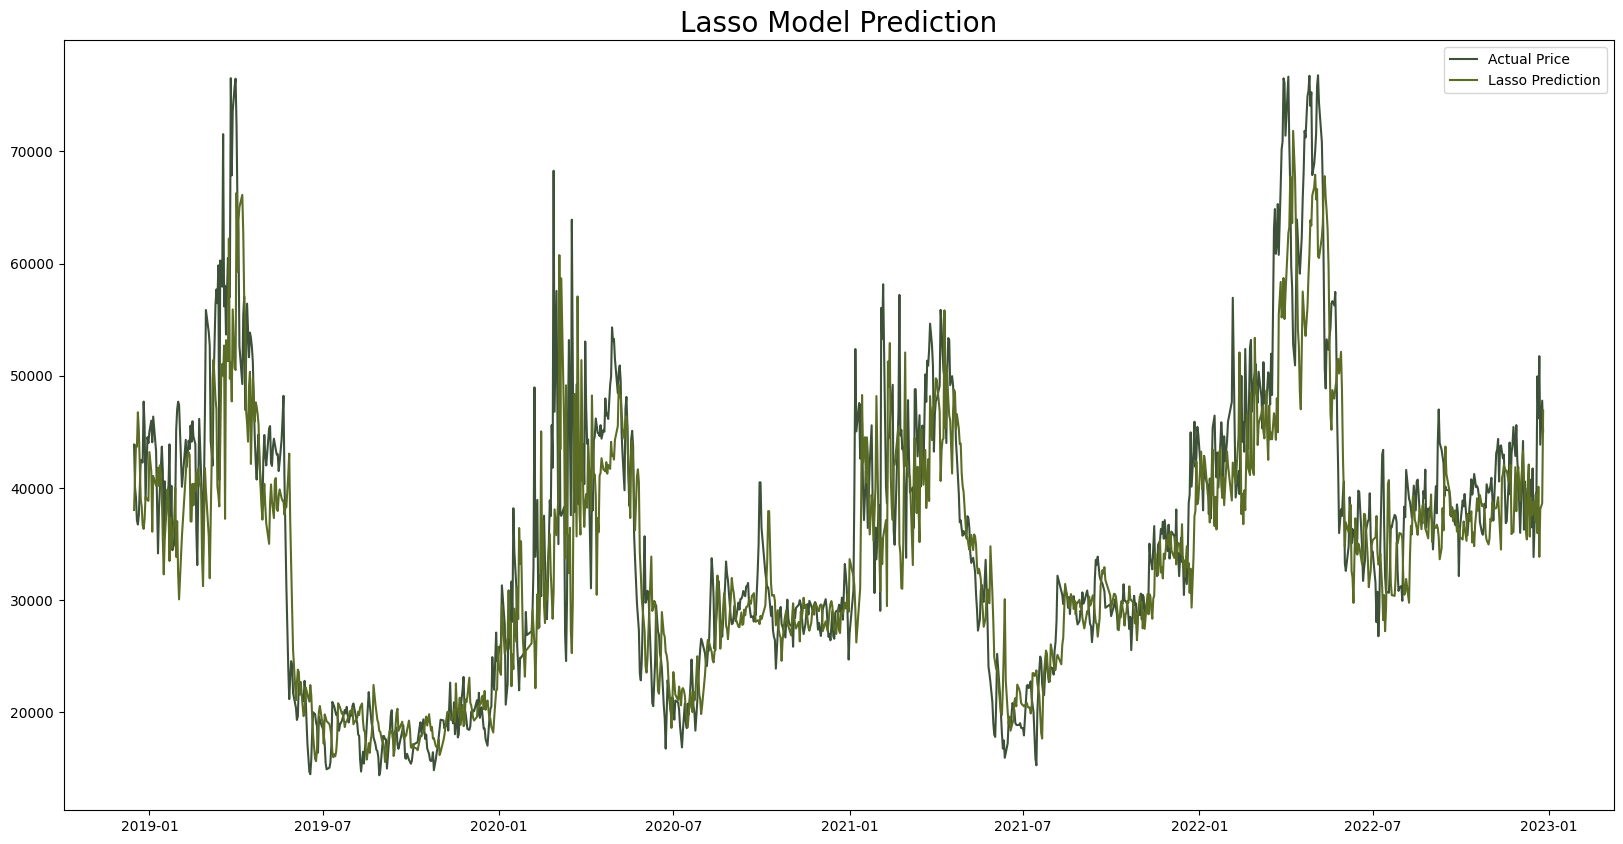

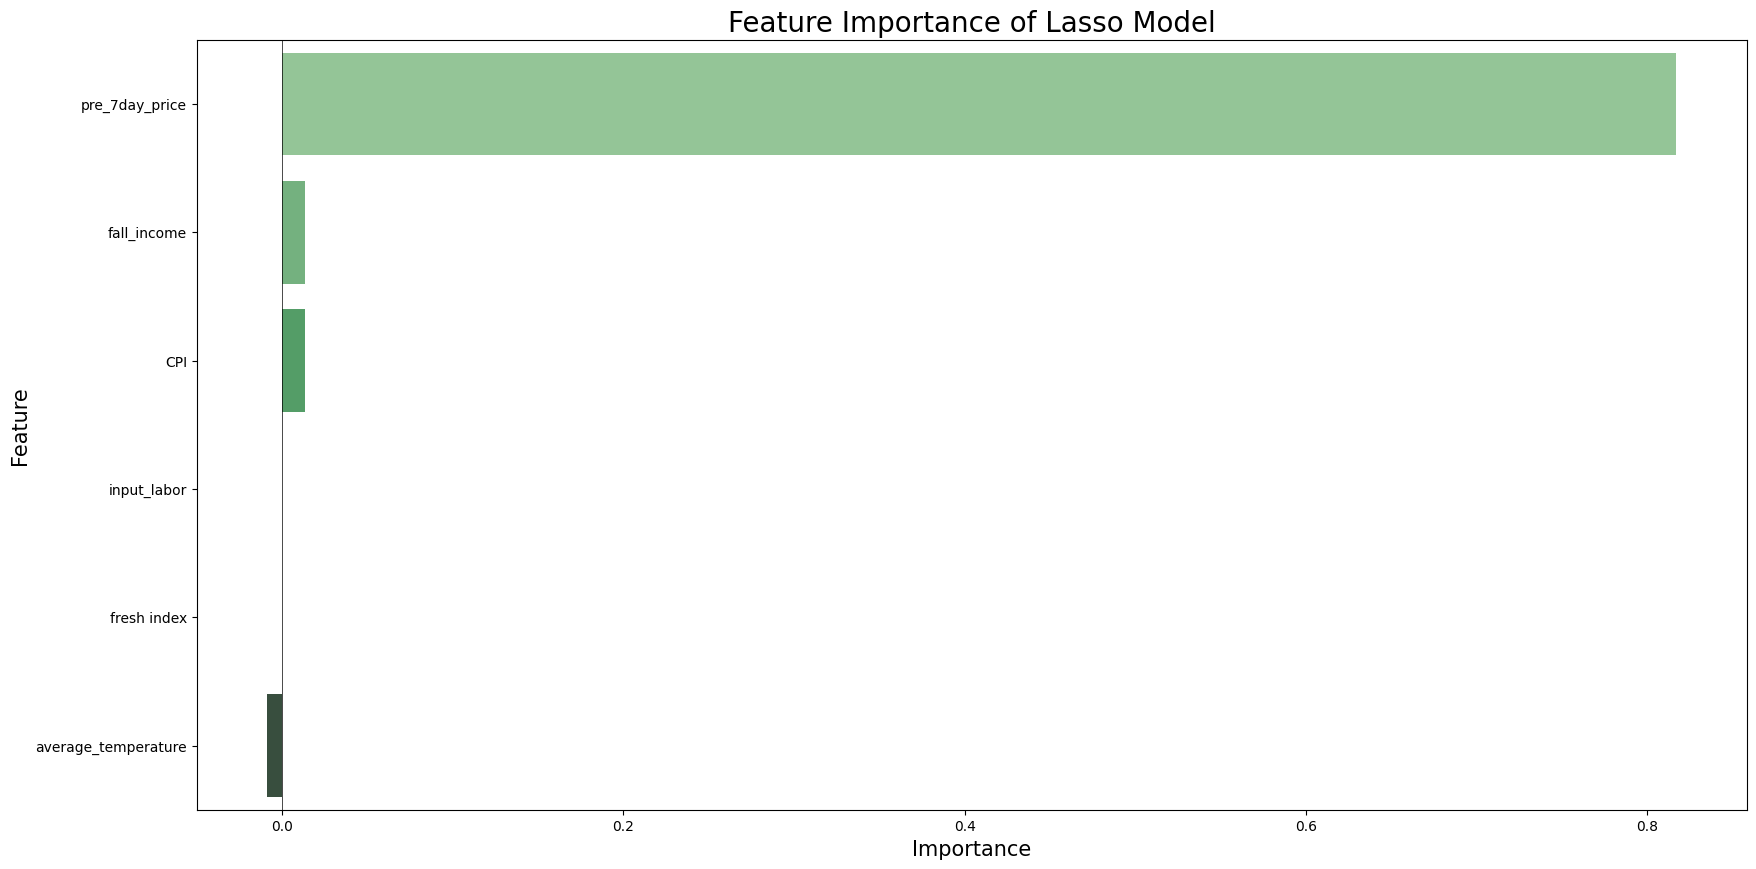

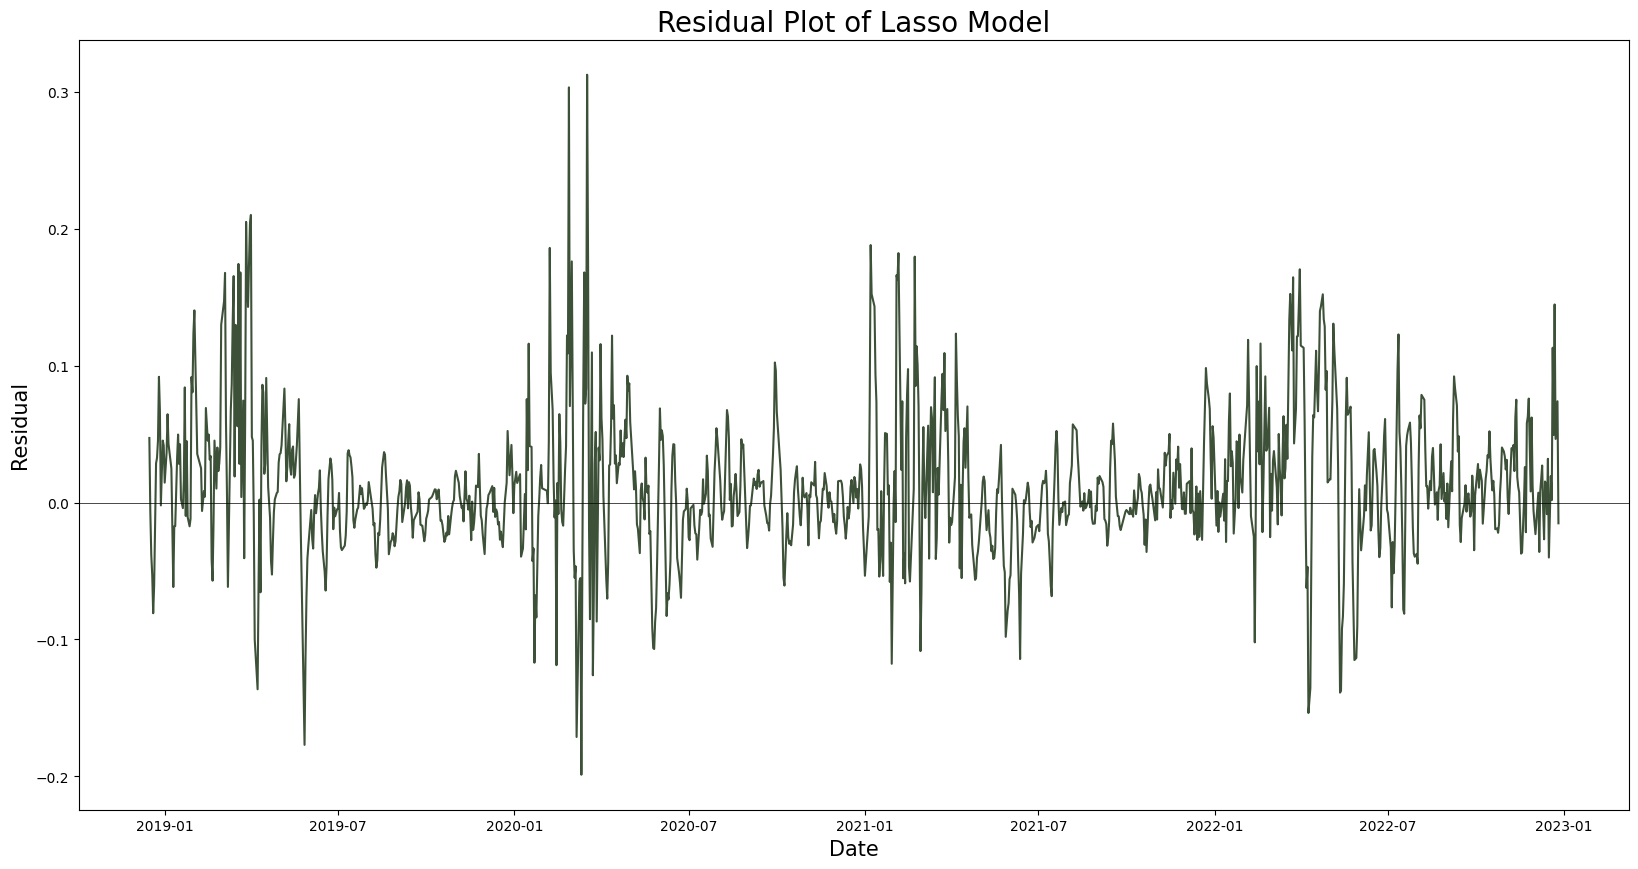

In [229]:
## -- include price Lasso model --

# part 1 : lasso model
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# input data and target data 
X = data[selected_variables]
y = data["avg_price"] 

# train set 80%, test set 20% 
train_size = int(len(data) * 0.8) 
X_train, X_test = X[:train_size], X[train_size:] 
y_train, y_test = y[:train_size], y[train_size:] 

# MinMaxScaler 
scaler = MinMaxScaler() 
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = scaler.fit_transform(np.array(y_train).reshape(-1, 1)).reshape(-1)
y_test = scaler.transform(np.array(y_test).reshape(-1, 1)).reshape(-1)

# lasso model 
lasso = Lasso() 
parameters = {"alpha": [0.001, 0.01, 0.1, 1, 10, 100, 1000]} 
lasso_regressor = GridSearchCV(lasso, parameters, scoring="neg_mean_squared_error", cv=5) 

lasso_regressor.fit(X_train, y_train) 
print("Best alpha: ", lasso_regressor.best_params_) 

# best alpha
best_alpha = lasso_regressor.best_params_["alpha"]

# retrain with best alpha
lasso = Lasso(alpha=best_alpha) 
lasso.fit(X_train, y_train) 

# prediction 
y_pred = lasso.predict(X_test) 

# evaluation 
lasso_mse = mean_squared_error(y_test, y_pred) 
print("MSE of optimized Lasso Regression model: ", lasso_mse)

# r-squared 
lasso_r2 = r2_score(y_test, y_pred)
print("R-squared of optimized Lasso Regression model: ", lasso_r2)

# dataframe of the result 
rescaled_y_test = scaler.inverse_transform(np.array(y_test).reshape(-1, 1)).reshape(-1) 
rescaled_y_pred = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).reshape(-1) 

result = pd.DataFrame({"Actual Price": rescaled_y_test, "Lasso Prediction": rescaled_y_pred}, index=index_date) 

# plot 
plt.figure(figsize=(20, 10)) 
plt.plot(result["Actual Price"], label="Actual Price", color="#3D5138") 
plt.plot(result["Lasso Prediction"], label="Lasso Prediction", color="#5B6C25") 
plt.title("Lasso Model Prediction", fontsize=20) 
plt.legend() 
plt.show() 

# part 2 : cofficients 
lasso_coef = pd.DataFrame({"Feature": X.columns, "Importance": lasso.coef_}) 
lasso_coef = lasso_coef.sort_values(by="Importance", ascending=False) 

plt.figure(figsize=(20, 10)) 
sns.barplot(x="Importance", y="Feature", data=lasso_coef, palette="Greens_d") 
plt.title("Feature Importance of Lasso Model", fontsize=20) 
plt.axvline(x=0, color="Black", linewidth=0.5) 
plt.xlabel("Importance", fontsize=15) 
plt.ylabel("Feature", fontsize=15) 
plt.show() 

# part 3 : residual plot 
residual = y_test - y_pred 
plt.figure(figsize=(20, 10)) 
plt.plot(index_date, residual, color="#3D5138") 
plt.axhline(y=0, color="Black", linewidth=0.5) 
plt.title("Residual Plot of Lasso Model", fontsize=20) 
plt.xlabel("Date", fontsize=15) 
plt.ylabel("Residual", fontsize=15) 
plt.show() 


/var/folders/0t/f_9d1d5d2qv03s28lgq_4b7r0000gn/T/ipykernel_87795/3763184505.py:13: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_train, y_test = y[:train_size], y[train_size:]


Best alpha:  {'alpha': 0.001}
MSE of optimized Ridge Regression model:  0.002600036730989349
R-squared of optimized Ridge Regression model:  0.7591255603354188


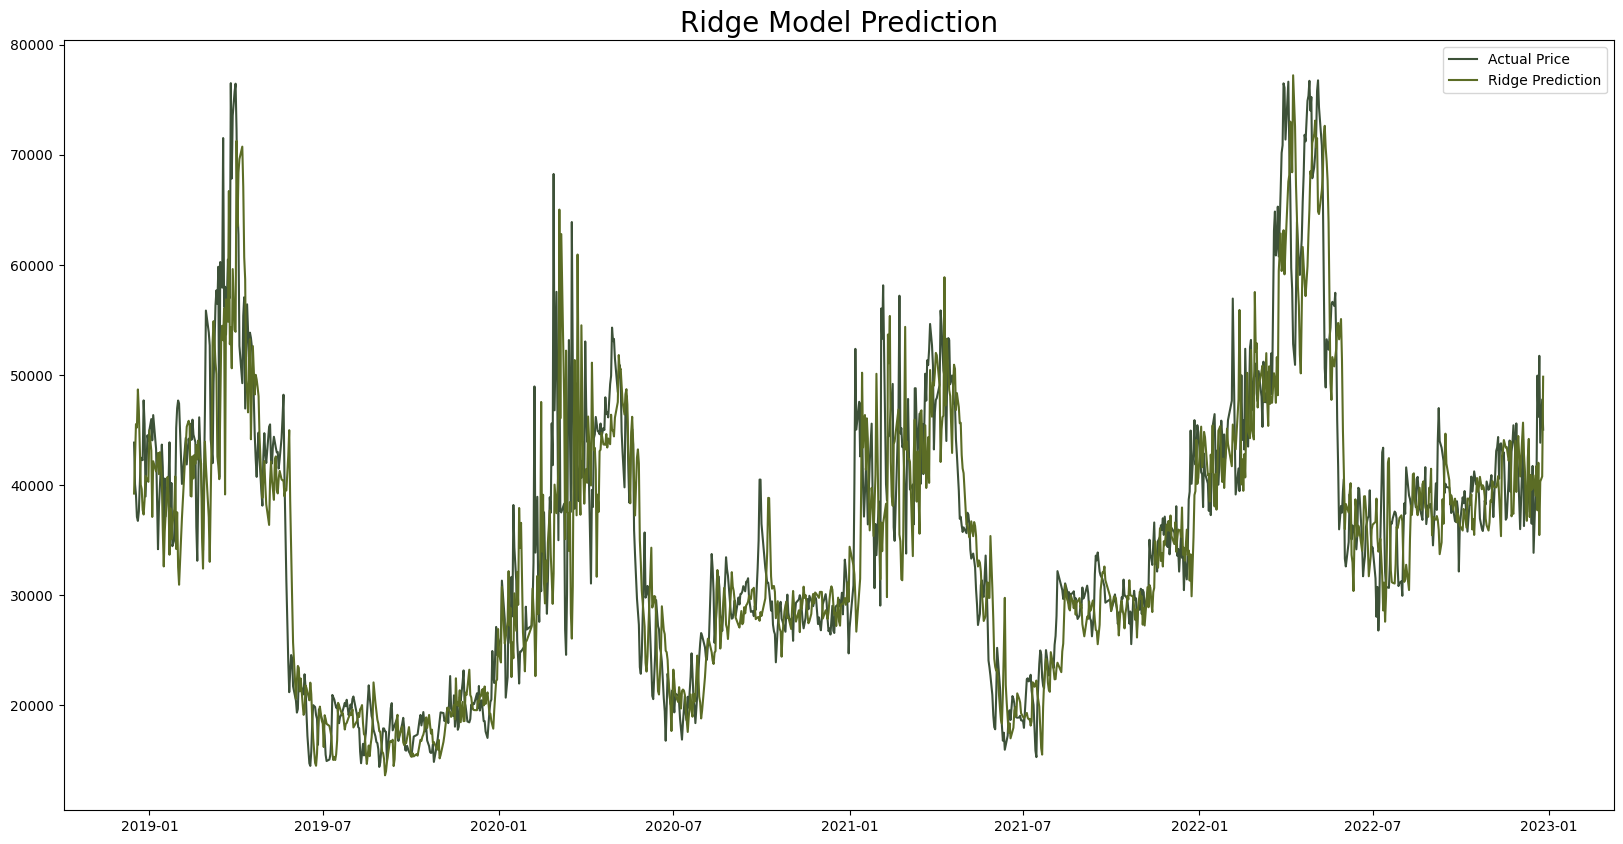

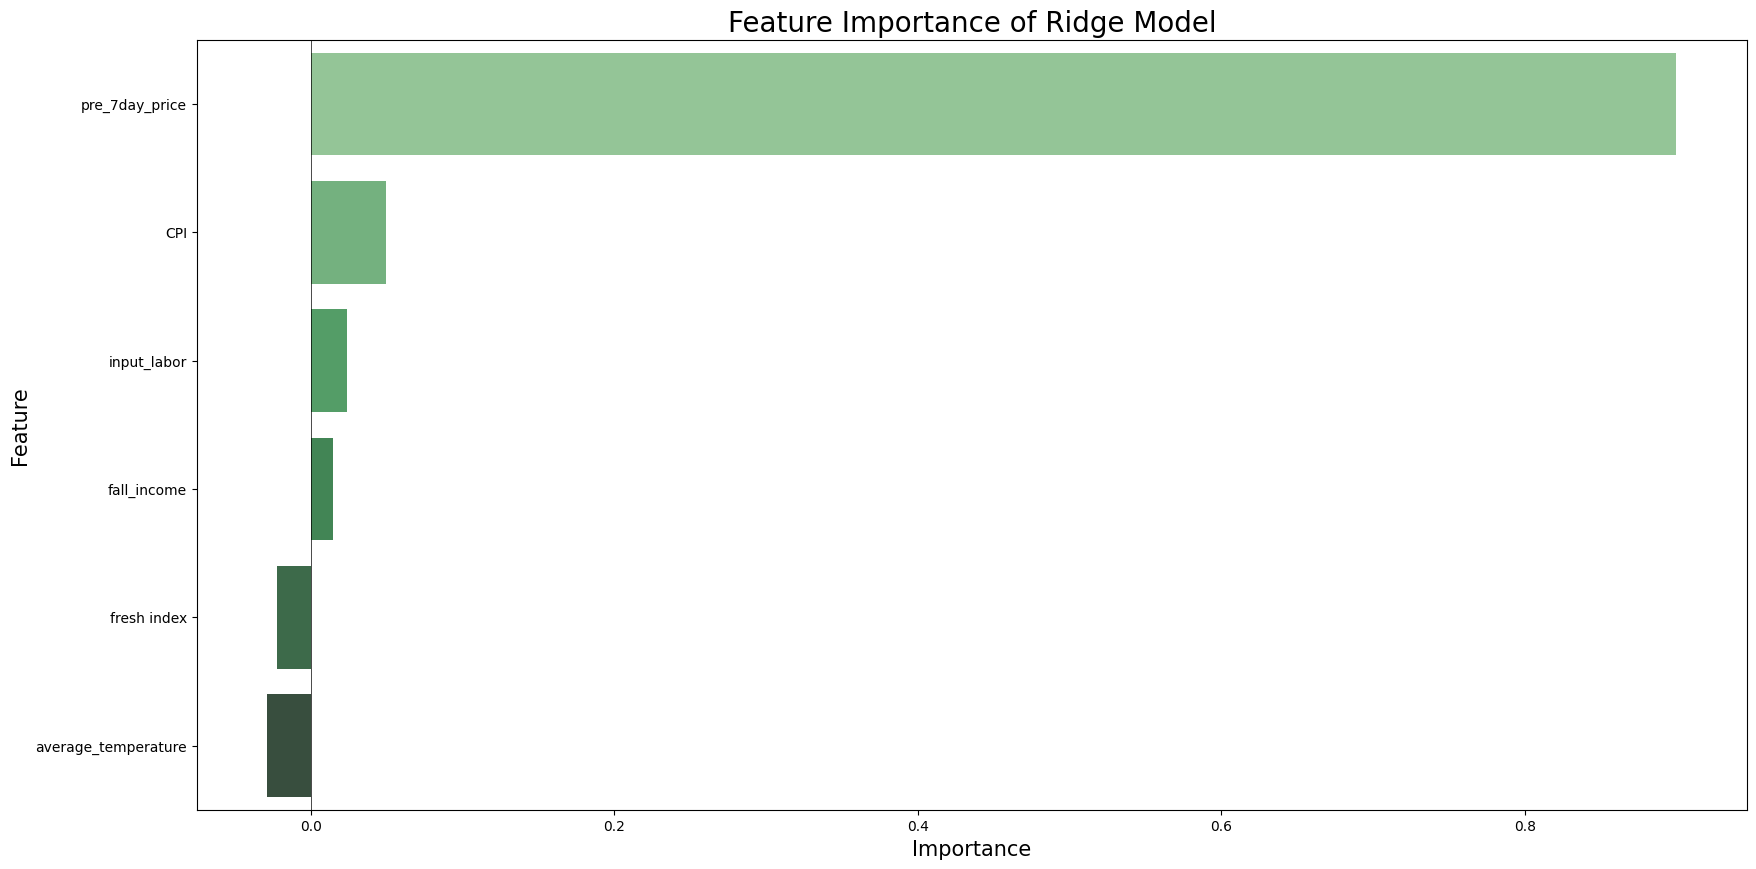

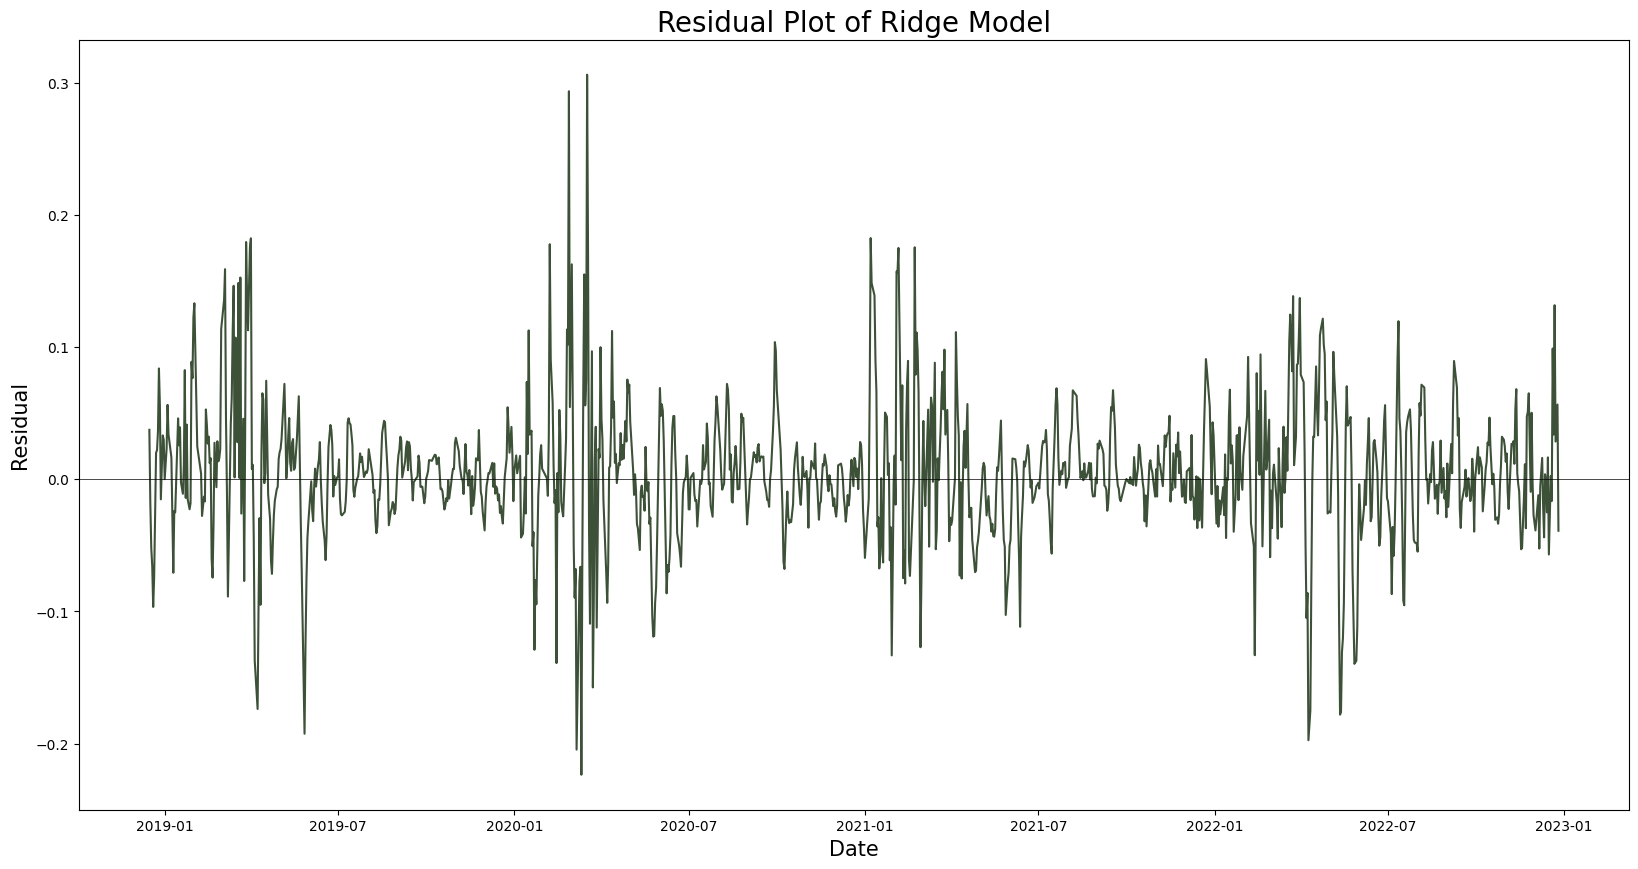

In [230]:
# -- include price Ridge model --

# part 1 : ridge model 
from sklearn.linear_model import Ridge 

# input data and target data 
X = data[selected_variables] 
y = data["avg_price"] 

# train set 80%, test set 20% 
train_size = int(len(data) * 0.8) 
X_train, X_test = X[:train_size], X[train_size:] 
y_train, y_test = y[:train_size], y[train_size:] 

# MinMaxScaler 
scaler = MinMaxScaler() 
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test) 
y_train = scaler.fit_transform(np.array(y_train).reshape(-1, 1)).reshape(-1) 
y_test = scaler.transform(np.array(y_test).reshape(-1, 1)).reshape(-1) 

# ridge model 
ridge = Ridge() 
parameters = {"alpha": [0.001, 0.01, 0.1, 1, 10, 100, 1000]} 
ridge_regressor = GridSearchCV(ridge, parameters, scoring="neg_mean_squared_error", cv=5) 

ridge_regressor.fit(X_train, y_train) 
print("Best alpha: ", ridge_regressor.best_params_) 

# best alpha 
best_alpha = ridge_regressor.best_params_["alpha"] 

# retrain with best alpha 
ridge = Ridge(alpha=best_alpha) 
ridge.fit(X_train, y_train) 

# prediction 
y_pred = ridge.predict(X_test) 

# evaluation 
ridge_mse = mean_squared_error(y_test, y_pred) 
print("MSE of optimized Ridge Regression model: ", ridge_mse) 

# r-squared
ridge_r2 = r2_score(y_test, y_pred)
print("R-squared of optimized Ridge Regression model: ", ridge_r2)


# dataframe of the result 
rescaled_y_test = scaler.inverse_transform(np.array(y_test).reshape(-1, 1)).reshape(-1) 
rescaled_y_pred = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).reshape(-1) 

result = pd.DataFrame({"Actual Price": rescaled_y_test, "Ridge Prediction": rescaled_y_pred}, index=index_date) 

# plot 
plt.figure(figsize=(20, 10))
plt.plot(result["Actual Price"], label="Actual Price", color="#3D5138")
plt.plot(result["Ridge Prediction"], label="Ridge Prediction", color="#5B6C25")
plt.title("Ridge Model Prediction", fontsize=20) 
plt.legend() 
plt.show()

# part 2 : coefficients
ridge_coef = pd.DataFrame({"Feature": X.columns, "Importance": ridge.coef_})
ridge_coef = ridge_coef.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(20, 10))
sns.barplot(x="Importance", y="Feature", data=ridge_coef, palette="Greens_d")
plt.title("Feature Importance of Ridge Model", fontsize=20)
plt.axvline(x=0, color="Black", linewidth=0.5)
plt.xlabel("Importance", fontsize=15)
plt.ylabel("Feature", fontsize=15)
plt.show()

# part 3 : residual plot
residual = y_test - y_pred
plt.figure(figsize=(20, 10))
plt.plot(index_date, residual, color="#3D5138")
plt.axhline(y=0, color="Black", linewidth=0.5)
plt.title("Residual Plot of Ridge Model", fontsize=20)
plt.xlabel("Date", fontsize=15)
plt.ylabel("Residual", fontsize=15)
plt.show()



/var/folders/0t/f_9d1d5d2qv03s28lgq_4b7r0000gn/T/ipykernel_87795/1075176842.py:13: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_train, y_test = y[:train_size], y[train_size:]


MSE of Ensemble Model:  0.00260654697109803
R-squared of Ensemble Model:  0.7585224340720204


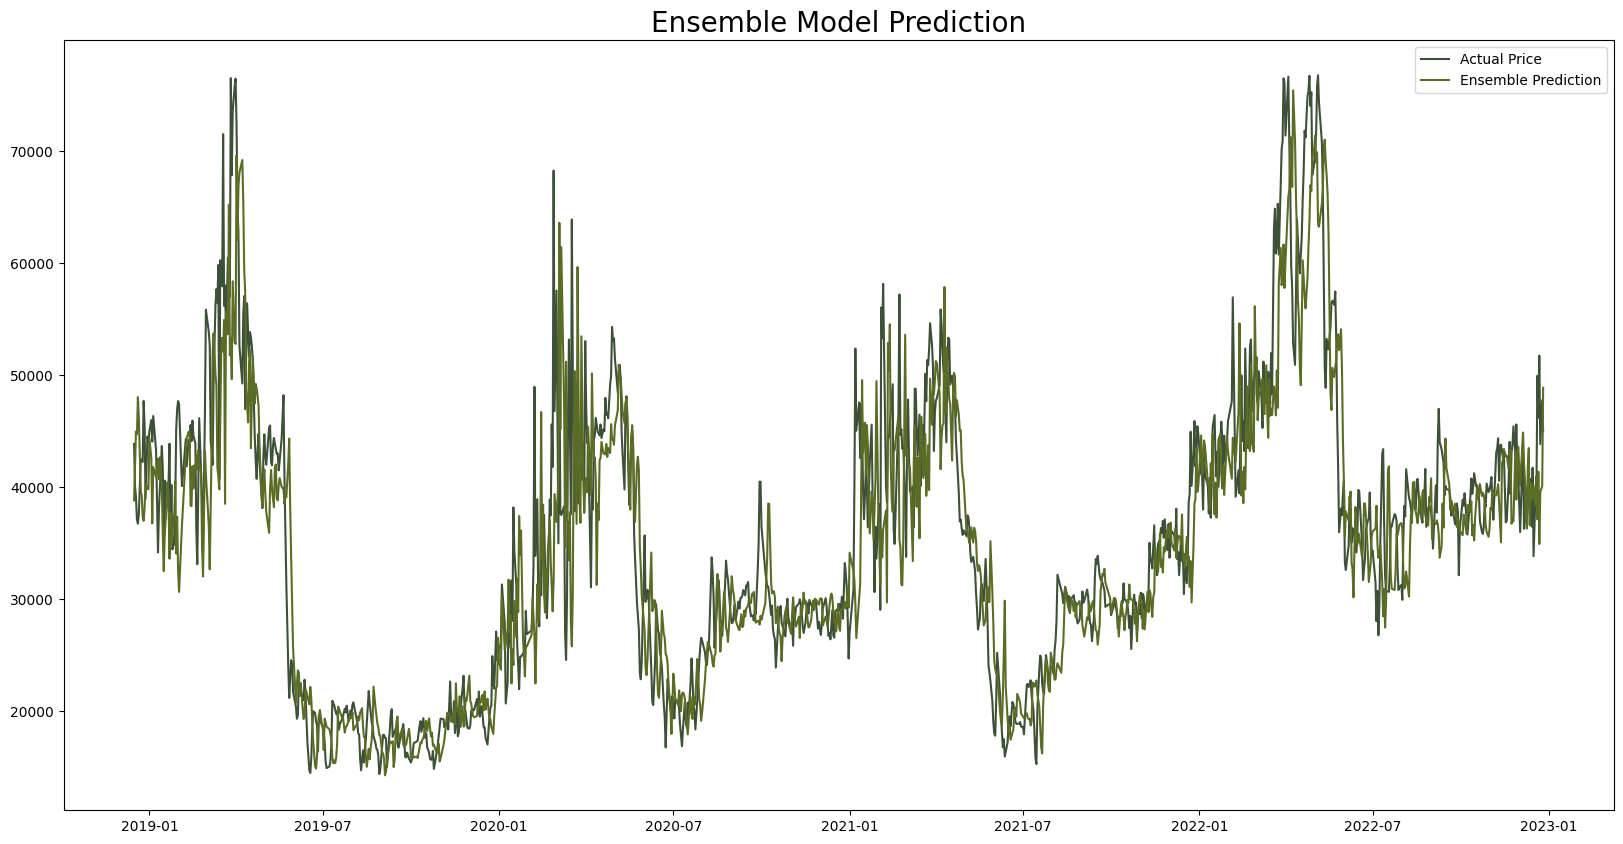

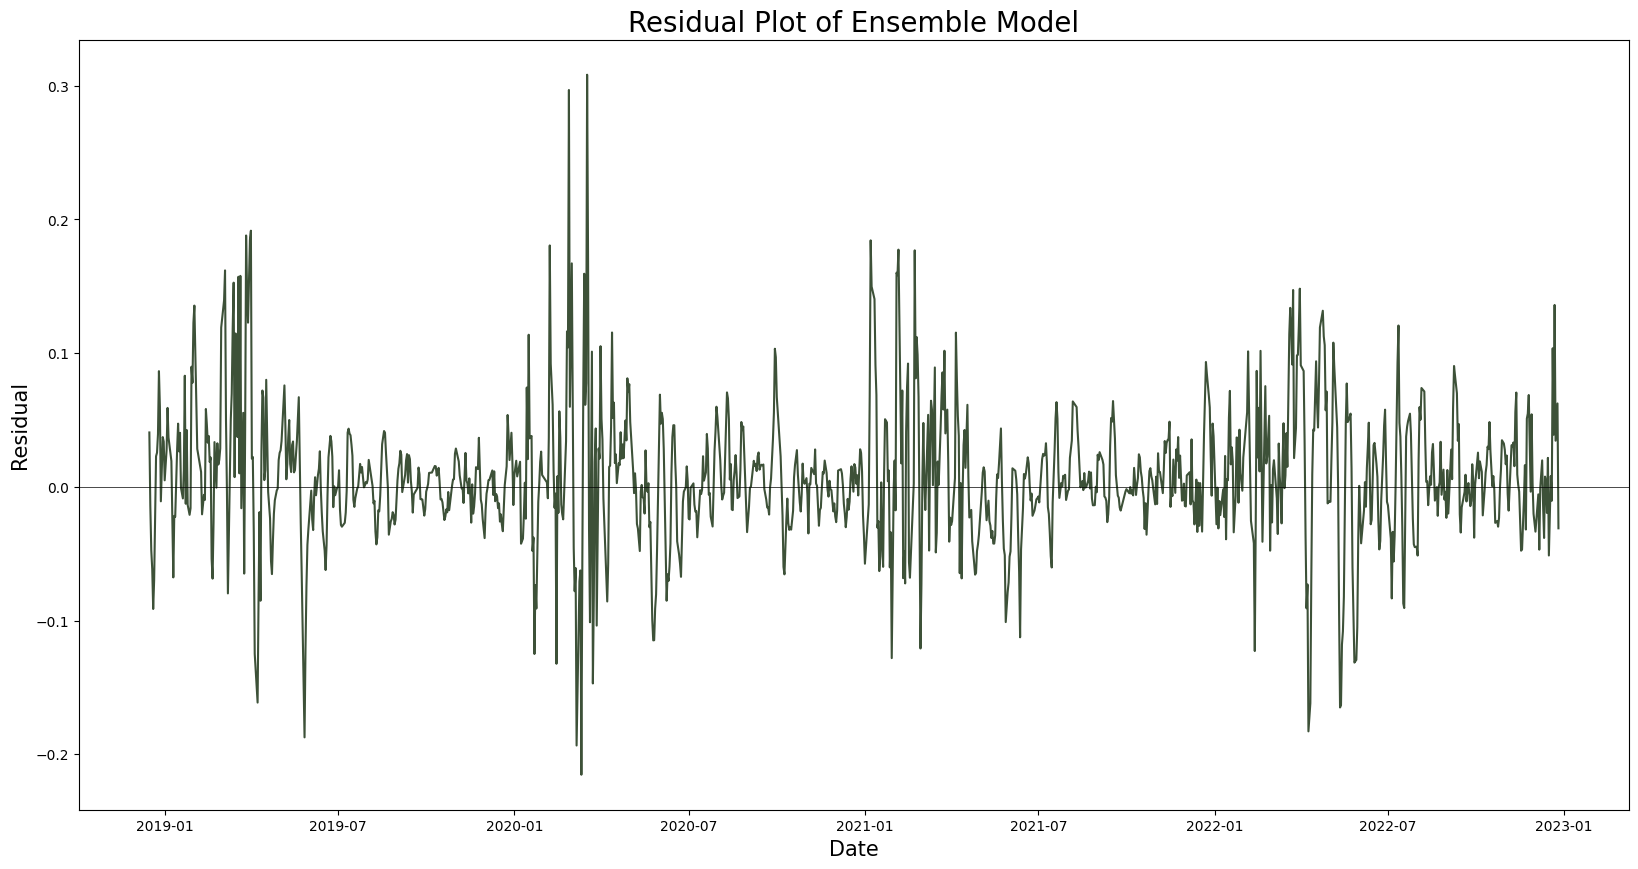

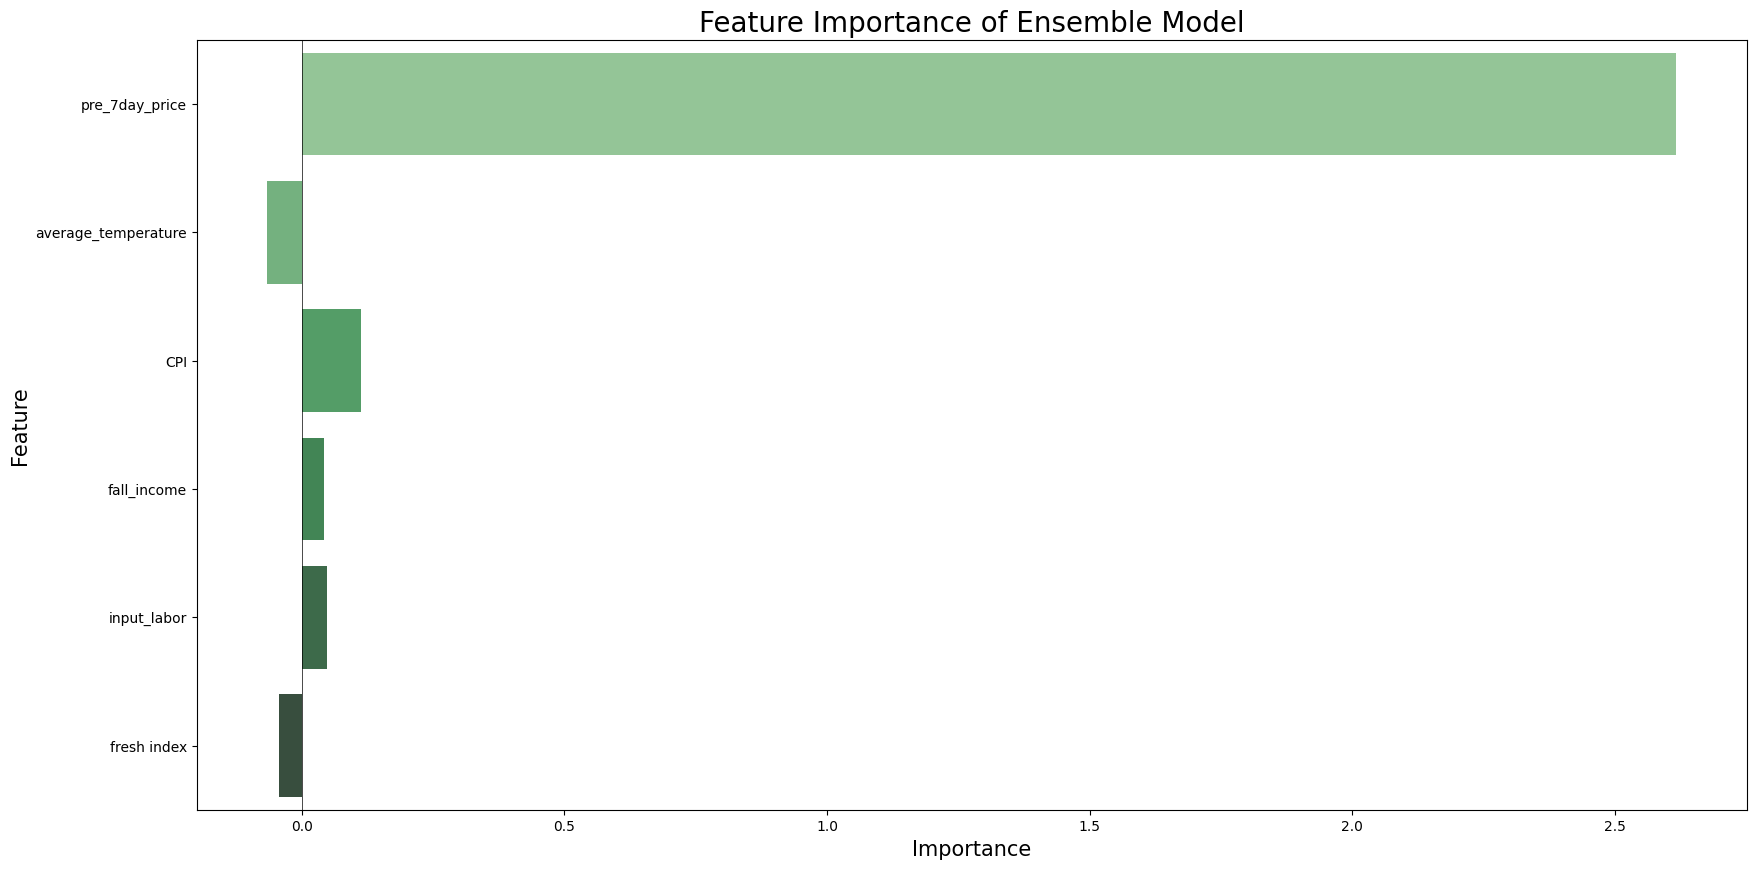

In [279]:
## -- include price ensemble model --

# part 1 : ensemble model
from sklearn.ensemble import VotingRegressor

# input data and target data
X = data[selected_variables]
y = data["avg_price"]

# train set 80%, test set 20%
train_size = int(len(data) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = scaler.fit_transform(np.array(y_train).reshape(-1, 1)).reshape(-1)
y_test = scaler.transform(np.array(y_test).reshape(-1, 1)).reshape(-1)

# models
lasso = Lasso(alpha=0.001)
ridge = Ridge(alpha=0.001)
linear = LinearRegression()

ensemble = VotingRegressor([("lasso", lasso), ("ridge", ridge), ("linear", linear)])

# fit
ensemble.fit(X_train, y_train)

# prediction 
y_pred = ensemble.predict(X_test) 

# evaluation 
ensemble_mse = mean_squared_error(y_test, y_pred)
print("MSE of Ensemble Model: ", ensemble_mse)

# r-squared
ensemble_r2 = r2_score(y_test, y_pred)
print("R-squared of Ensemble Model: ", ensemble_r2)

# dataframe of the result 
rescaled_y_test = scaler.inverse_transform(np.array(y_test).reshape(-1, 1)).reshape(-1) 
rescaled_y_pred = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).reshape(-1) 

result = pd.DataFrame({"Actual Price": rescaled_y_test, "Ensemble Prediction": rescaled_y_pred}, index=index_date) 

# plot 
plt.figure(figsize=(20, 10)) 
plt.plot(result["Actual Price"], label="Actual Price", color="#3D5138") 
plt.plot(result["Ensemble Prediction"], label="Ensemble Prediction", color="#5B6C25") 
plt.title("Ensemble Model Prediction", fontsize=20) 
plt.legend() 
plt.show() 

# part 2 : residual plot 
residual = y_test - y_pred 
plt.figure(figsize=(20, 10)) 
plt.plot(index_date, residual, color="#3D5138")
plt.axhline(y=0, color="Black", linewidth=0.5)
plt.title("Residual Plot of Ensemble Model", fontsize=20)
plt.xlabel("Date", fontsize=15)
plt.ylabel("Residual", fontsize=15)
plt.show()

# part 3 : coefficients
lasso_coef = ensemble.named_estimators_["lasso"].coef_
ridge_coef = ensemble.named_estimators_["ridge"].coef_
linear_coef = ensemble.named_estimators_["linear"].coef_
ensemble_coef = np.sum([lasso_coef, ridge_coef, linear_coef], axis=0)
ensemble_coef = pd.DataFrame({"Feature": X.columns, "Importance": ensemble_coef})

plt.figure(figsize=(20, 10))
sns.barplot(x="Importance", y="Feature", data=ensemble_coef, palette="Greens_d")
plt.title("Feature Importance of Ensemble Model", fontsize=20)
plt.axvline(x=0, color="Black", linewidth=0.5)
plt.xlabel("Importance", fontsize=15)
plt.ylabel("Feature", fontsize=15)
plt.show()





/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


MSE of ARIMA model:  0.009393674558200673
R-squared of ARIMA model:  0.7795423081708839


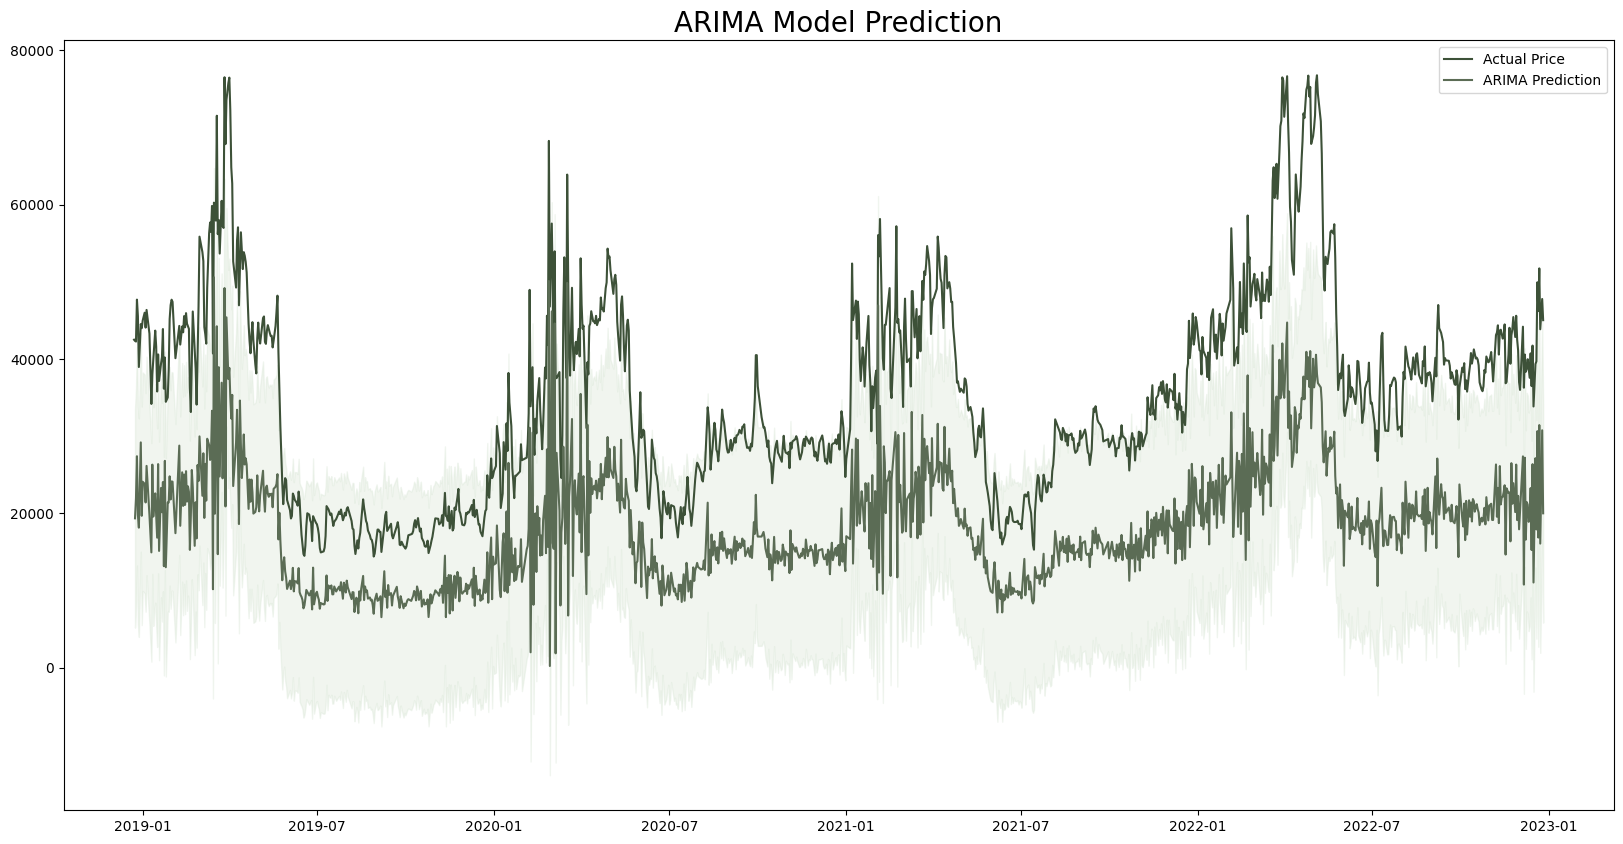

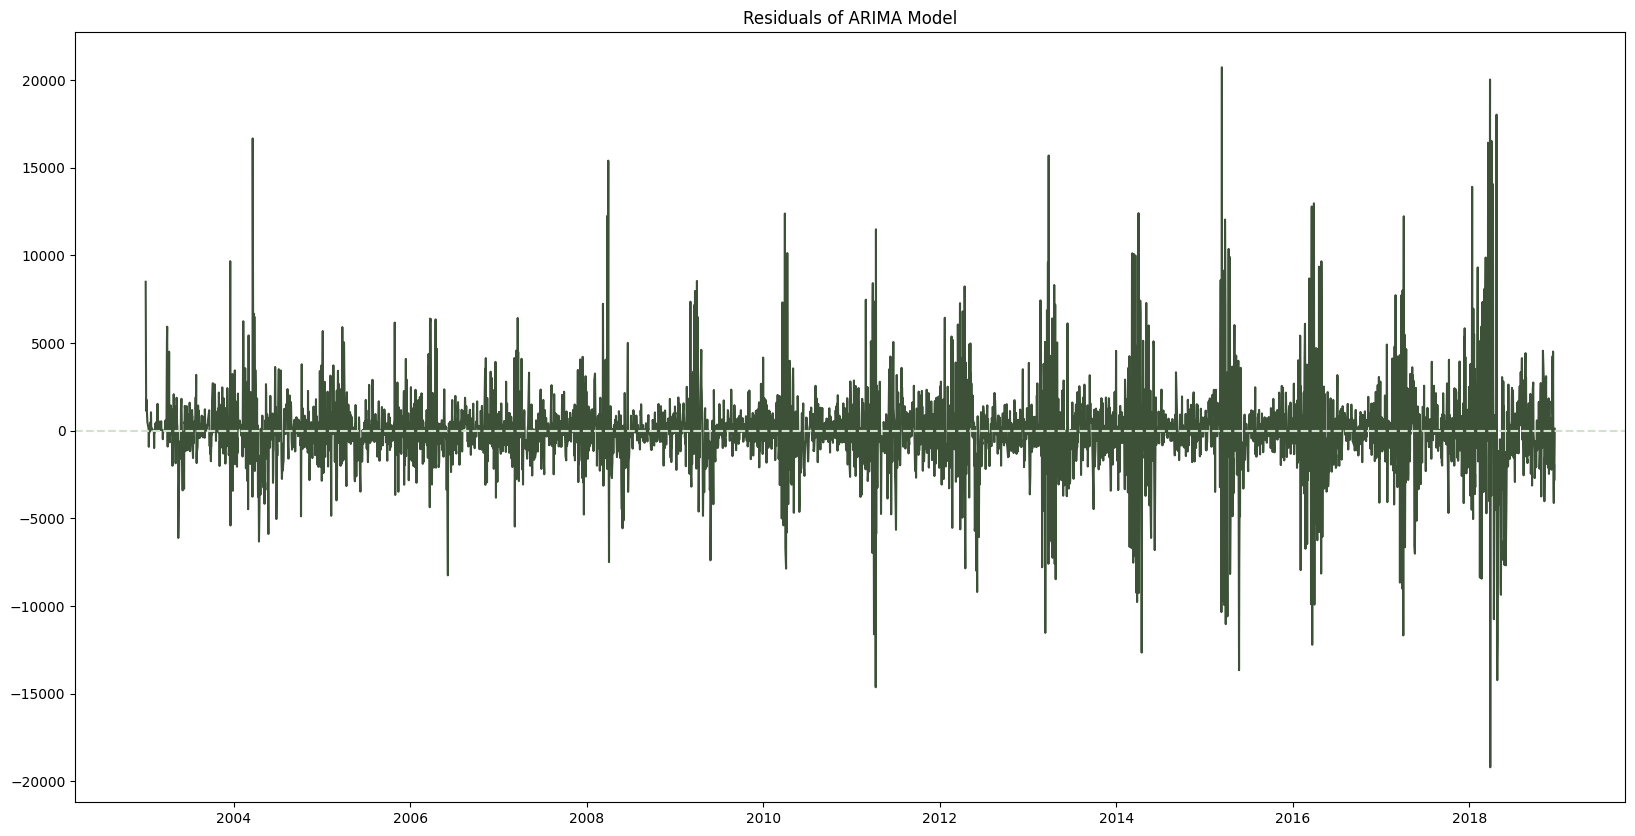

                               SARIMAX Results                                
Dep. Variable:              avg_price   No. Observations:                 6118
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -56914.684
Date:                Mon, 25 Nov 2024   AIC                         113835.368
Time:                        12:22:36   BIC                         113855.525
Sample:                             0   HQIC                        113842.361
                               - 6118                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5187      0.021     25.210      0.000       0.478       0.559
ma.L1         -0.7007      0.018    -38.919      0.000      -0.736      -0.665
sigma2      7.133e+06    4.8e+04    148.724      0.0

In [235]:
## -- ARIMA model -- ##

# Load the data
load_data = pd.read_excel("core_data.xlsx")

# Drop the missing values
data = load_data.drop(["pre_day_price", "pre_year_price", "pre_7day_price"], axis=1)

# using by variables of arima model
target_arima = data["avg_price"]

# index of tartget_arima with date
target_arima.index = data["DATE"]

# build the model with ARIMA
from statsmodels.tsa.arima.model import ARIMA

ARIMA_model = ARIMA(target_arima, order=(1, 1, 1))
ARIMA_model_fit = ARIMA_model.fit()

# coefficient of the model
phi = ARIMA_model_fit.params[0]
theta = ARIMA_model_fit.params[1]
residuals = ARIMA_model_fit.resid

# forecast the future price
ARIMA_preds = []

for i in range(1, len(target_arima)):
    arima_pred = phi * target_arima[i - 1] + theta * residuals[i - 1] + residuals[i]
    ARIMA_preds.append(arima_pred)

# evaluation of the model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import minmax_scale

train_size = int(len(target_arima) * 0.8)
arime_test = target_arima[train_size:]
arima_test = minmax_scale(arime_test)

ARIMA_preds_test = ARIMA_preds[train_size:]
ARIMA_preds_test = minmax_scale(ARIMA_preds_test)

airma_mse = mean_squared_error(arima_test[1:], ARIMA_preds_test)
print("MSE of ARIMA model: ", airma_mse)

# r-squared
from sklearn.metrics import r2_score

arima_r2 = r2_score(arima_test[1:], ARIMA_preds_test)
print("R-squared of ARIMA model: ", arima_r2)


# 95% confidence interval
ARIMA_preds = pd.Series(ARIMA_preds, index=target_arima[1:].index)
sigma_test = sqrt(ARIMA_preds.var())
lower = ARIMA_preds - 1.96 * sigma_test
upper = ARIMA_preds + 1.96 * sigma_test

# dataframe of the result
result = pd.DataFrame({"Actual Price": target_arima[train_size:],
                        "ARIMA Prediction": ARIMA_preds[train_size:],
                         "Lower": lower[train_size:], "Upper": upper[train_size:]})


# plot the result 
plt.figure(figsize=(20, 10))
plt.plot(result["Actual Price"], label="Actual Price", color="#3D5138") 
plt.plot(result["ARIMA Prediction"], label="ARIMA Prediction", color="#5B6C55") 
plt.fill_between(result.index, result["Lower"], result["Upper"], color='#D1E1CD', alpha=0.3) 
plt.legend() 
plt.title("ARIMA Model Prediction", fontsize=20) 
plt.show() 


# plot the residual
plt.figure(figsize=(20, 10))
plt.plot(residuals[:train_size],  color="#3D5138")
plt.axhline(y=0, color='#D1E1CD', linestyle='--')
plt.title("Residuals of ARIMA Model")
plt.show() 

# summary of the ARIMA model
print(ARIMA_model_fit.summary())


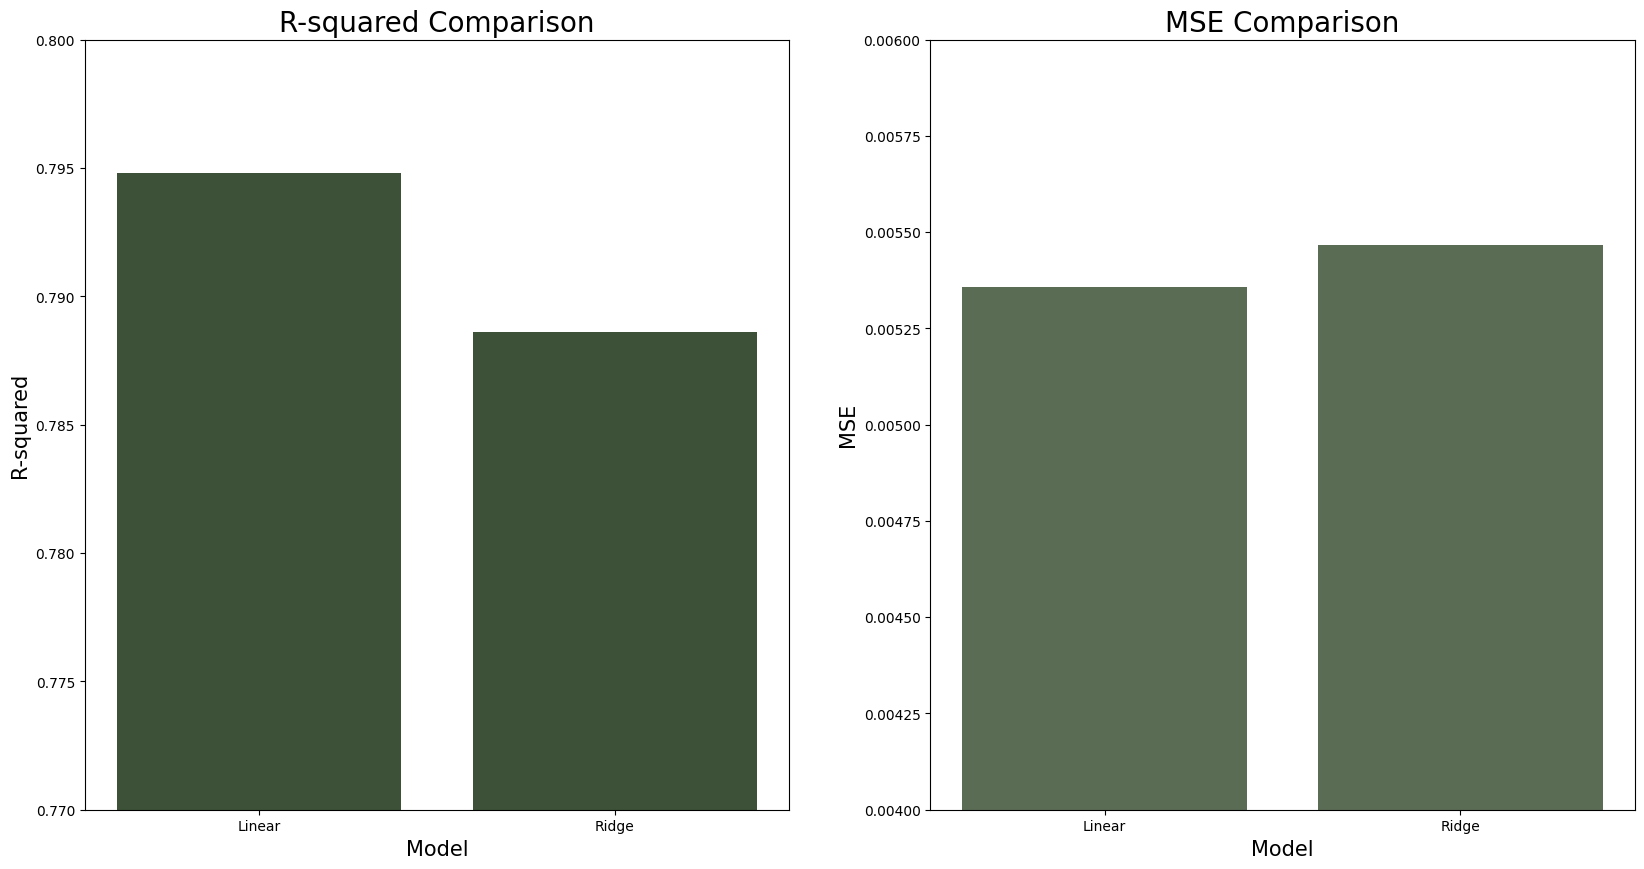

In [238]:

# -- timeseries cross validation --
from sklearn.model_selection import TimeSeriesSplit 

# timeseries cross validation
tscv = TimeSeriesSplit(n_splits=7)

data = pd.read_excel("core_data.xlsx").dropna()
X = data[selected_variables].values
y = data["avg_price"].values


# linear regression
lr_r2_fold = []
lr_mse_fold = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    y_train = scaler.fit_transform(np.array(y_train).reshape(-1, 1)).reshape(-1)
    y_test = scaler.transform(np.array(y_test).reshape(-1, 1)).reshape(-1)
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    
    lr_r2_fold.append(r2_score(y_test, y_pred))
    lr_mse_fold.append(mean_squared_error(y_test, y_pred))

# ridge regression
ridge_r2_fold = []
ridge_mse_fold = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    y_train = scaler.fit_transform(np.array(y_train).reshape(-1, 1)).reshape(-1)
    y_test = scaler.transform(np.array(y_test).reshape(-1, 1)).reshape(-1)
    
    
    ridge = Ridge()
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
    
    ridge_r2_fold.append(r2_score(y_test, y_pred))
    ridge_mse_fold.append(mean_squared_error(y_test, y_pred))




# plot mean of r-squared and mse
r2 = [np.mean(lr_r2_fold), np.mean(ridge_r2_fold)] 
mse = [np.mean(lr_mse_fold), np.mean(ridge_mse_fold)]

plt.figure(figsize=(20, 10)) 
plt.subplot(1, 2, 1)
plt.bar(["Linear", "Ridge"], r2, color="#3D5138")
plt.title("R-squared Comparison", fontsize=20)
plt.xlabel("Model", fontsize=15)
plt.ylabel("R-squared", fontsize=15)
plt.ylim(.77, .8)

plt.subplot(1, 2, 2)
plt.bar(["Linear", "Ridge"], mse, color="#5B6C55")
plt.title("MSE Comparison", fontsize=20)
plt.xlabel("Model", fontsize=15)
plt.ylabel("MSE", fontsize=15)
plt.ylim(.004, 0.006)

plt.show()



In [258]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 데이터 로드 및 인덱스 설정
df = pd.read_excel("core_data.xlsx")
df.set_index("DATE", inplace=True)

# 가격관련 독립변수 드랍
delete_columns = ["pre_day_price", "pre_year_price"]
df = df.drop(columns=delete_columns, errors="ignore")

# 주요 변수 선택 및 정규화
target = "avg_price"
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[[target]])

# 시계열 데이터 윈도우 생성
sequence_length = 30  # 과거 30일치 데이터로 예측
X, y = [], []
for i in range(sequence_length, len(df_scaled)):
    X.append(df_scaled[i-sequence_length:i, 0])
    y.append(df_scaled[i, 0])
X, y = np.array(X), np.array(y)

# 데이터셋 분할 (80% 훈련, 20% 테스트)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 입력 데이터를 LSTM 입력 형태로 재구성 (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# LSTM 모델 구축
model = Sequential([
    # 첫 번째 LSTM 레이어
    LSTM(50, activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),

    # 두 번째 LSTM 레이어
    LSTM(50, activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=False),
    Dropout(0.2),

    # 출력 레이어
    Dense(25, activation='relu'),  # 출력 전 추가 Dense 레이어 (ReLU 활성화 함수)
    Dense(1, activation='linear')  # 최종 출력 레이어 (회귀 문제용)
])

# 모델 컴파일
model.compile(optimizer="adam", loss="mean_squared_error")

# 모델 학습
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=0)

# 예측 수행 (정규화된 값 사용)
test_predict = model.predict(X_test)

# 모델 평가 (MSE, 정규화된 값 기준)
lstm_r2 = r2_score(y_test, test_predict)
lstm_mse = mean_squared_error(y_test, test_predict[:, 0])
print("Test MSE (Normalized):", lstm_mse)

# reverse scaling
rescaled_y_test = scaler.inverse_transform(np.array(y_test).reshape(-1, 1)).reshape(-1)
rescaled_y_pred = scaler.inverse_transform(np.array(test_predict).reshape(-1, 1)).reshape(-1)

# dataframes for plotting
result_lstm = pd.DataFrame({"y_true": rescaled_y_test, "y_pred": rescaled_y_pred}, index=df.index[-len(rescaled_y_test):])

# plot
plt.figure(figsize=(20, 10))
plt.plot(result_lstm["y_true"], label="True", color="#5B6C55")
plt.plot(result_lstm["y_pred"], label="Predicted", color="#3D5138")
plt.title("LSTM Model Prediction", fontsize=20)
plt.xlabel("Index", fontsize=15)
plt.ylabel("Price", fontsize=15)
plt.legend()
plt.show()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Test MSE (Normalized): 0.0009093549537706538


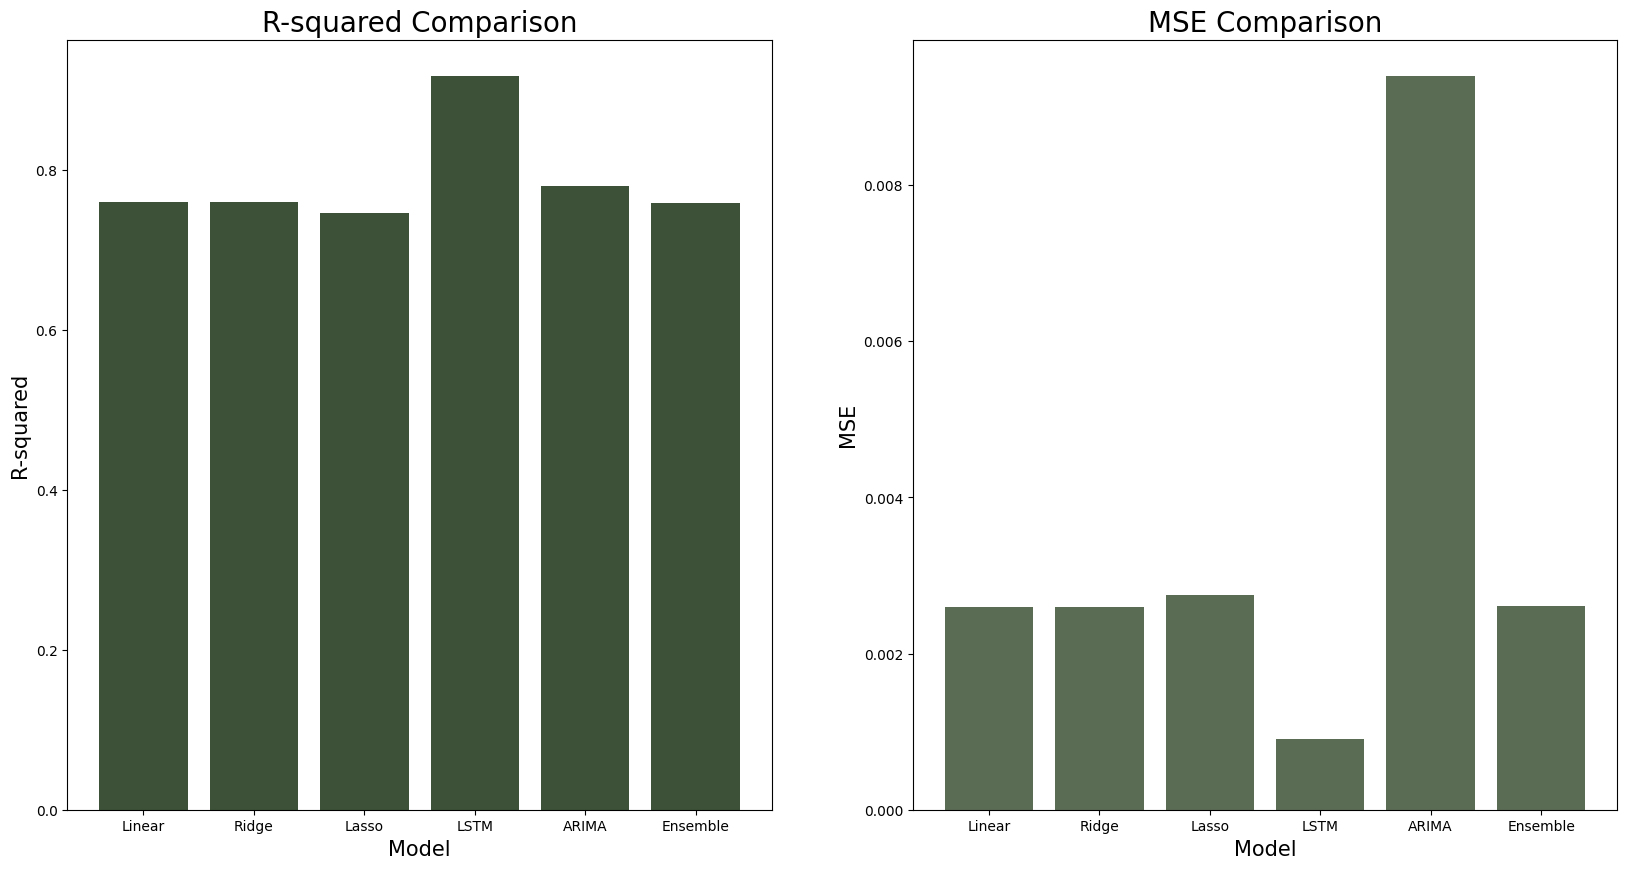

In [278]:
# -- comprison all models -- #
r2 = [lr_r2, ridge_r2, lasso_r2, lstm_r2, arima_r2, ensemble_r2]
mse = [lr_mse, ridge_mse, lasso_mse, lstm_mse, airma_mse, ensemble_mse]

# plot
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1) 
plt.bar(["Linear", "Ridge", "Lasso", "LSTM", "ARIMA", "Ensemble"], r2, color="#3D5138") 
plt.title("R-squared Comparison", fontsize=20) 
plt.xlabel("Model", fontsize=15) 
plt.ylabel("R-squared", fontsize=15) 

plt.subplot(1, 2, 2)
plt.bar(["Linear", "Ridge", "Lasso", "LSTM", "ARIMA", "Ensemble"], mse, color="#5B6C55") 
plt.title("MSE Comparison", fontsize=20) 
plt.xlabel("Model", fontsize=15) 
plt.ylabel("MSE", fontsize=15) 

plt.show() 

ValueError: masker cannot be None.